## This notebook will be used for the DataScience Capstone Project

In [3]:
!conda install -c conda-forge folium=0.5.0 --yes
#conda install --override-channels -c main package_in_main

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import ibm_db
import ibm_db_dbi
import geopy
from geopy.geocoders import Nominatim
import geopy.distance
import folium
from folium import plugins
from folium.plugins import HeatMap
import requests
import urllib3
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [68]:
#Get data of hotspots of Covid19 cases in rio, then get hospitals to select for testing 

In [115]:
# The code was removed by Watson Studio for sharing.

DRIVER={IBM DB2 ODBC DRIVER};DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-dal09-10.services.dal.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=qhz88534;PWD=kgmh49n^49fmbqs3;
Connected to database:  BLUDB as user:  qhz88534 on host:  dashdb-txn-sbox-yp-dal09-10.services.dal.bluemix.net


In [6]:
#Getting neighbourhood and postal code for all reported cases in the city and creating a dataframe with this information.
sql = 'select BAIRRO,CEP from COVID_RJ'
df_cases = pd.read_sql(sql, hdbi)
df_cases.columns = ['NEIGHBOURHOOD', 'POSTAL_CODE']
df_cases.head()

,NEIGHBOURHOOD,POSTAL_CODE
0,CACHAMBI,20771330
1,TIJUCA,20261120
2,JACAREPAGUA,22753211
3,BENFICA,20910250
4,SANTISSIMO,23094140


In [7]:
# Checking the total number of cases reported in the city
df_cases.shape

(61407, 2)

In [8]:
# Creating a dataframe with the number of cases in each neighbourhood
df_cases['TOTAL_CASES'] = 1
df_neighbourhood = df_cases.groupby('NEIGHBOURHOOD').count()[['TOTAL_CASES']].reset_index()
df_neighbourhood['NEIGHBOURHOOD'] = df_neighbourhood['NEIGHBOURHOOD'].str.lower()
df_neighbourhood.sort_values('TOTAL_CASES', ascending=False).head()

,NEIGHBOURHOOD,TOTAL_CASES
35,copacabana,2768
9,barra da tijuca,2713
138,tijuca,2580
23,campo grande,2507
8,bangu,1708


In [9]:
#Getting latitude & longitude information for all neighbourhoods in the dataframe
list_lat = []
list_long = []

for index, row in df_neighbourhood.iterrows(): # iterate over rows in dataframe
    Neighbourhood = row['NEIGHBOURHOOD']
    geolocator = Nominatim(user_agent="rj_explorer", timeout=3)
    location = geolocator.geocode(Neighbourhood + ', RJ')
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
 
    else:
        latitude = None
        longitude = None
        
    list_lat.append(latitude)
    list_long.append(longitude)
    
df_neighbourhood['LATITUDE'] = list_lat   
df_neighbourhood['LONGITUDE'] = list_long
df_neighbourhood.head()


,NEIGHBOURHOOD,TOTAL_CASES,LATITUDE,LONGITUDE
0,abolicao,129,-22.886161,-43.299846
1,acari,105,-22.822153,-43.340674
2,agua santa,68,-22.911143,-43.312126
3,alto da boa vista,109,-22.962113,-43.253582
4,anchieta,497,-22.823190,-43.399107


In [10]:
# Checking for nan values
df_neighbourhood.isnull().sum()
df_neighbourhood[pd.isnull(df_neighbourhood).any(axis=1)]

# Since there is no location information for this neighbourhood, and it is only 1 without it, it will be removed to avoid future issues
# while handling the data
df_neighbourhood.drop([51], axis=0, inplace=True)
df_neighbourhood.shape

(156, 4)

In [11]:
#Getting latitude & longitude of the city of Rio de Janeiro
address = 'Rio de Janeiro'
geolocator = Nominatim(user_agent="RJ_explorer")
location = geolocator.geocode(address)
latitude_RJ = location.latitude
longitude_RJ = location.longitude
        
print('The geograpical coordinate of Rio de Janeiro are {}, {}.'.format(latitude_RJ, longitude_RJ))

The geograpical coordinate of Rio de Janeiro are -22.9110137, -43.2093727.


In [12]:
# Create Map of Rio de Janeiro
m = folium.Map(location=[latitude_RJ, longitude_RJ], tiles="Stamen Terrain", zoom_start=10.5)

# Add circles to identify hotspots
for lat, lng, name, value in zip(df_neighbourhood['LATITUDE'], df_neighbourhood['LONGITUDE'], df_neighbourhood['NEIGHBOURHOOD'], df_neighbourhood['TOTAL_CASES']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=value,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.4,
        parse_html=False).add_to(m)  
    
m

In [ ]:
# The code was removed by Watson Studio for sharing.

In [14]:
# Creating function to get hospitals from Foursquare for all neighbourhoods
def getNearbyHospitals(names, latitudes, longitudes):
    radius=500    
    LIMIT=100
    cat_Id ='4bf58dd8d48988d196941735' #Hospital category in Foursquare
    query = 'Hospital'
    hospitals_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
    # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT, query)

        
    # make the GET request
        results = requests.get(url).json()["response"]["venues"]
    
    # return only relevant information for each nearby venue
        hospitals_list.append([(
            name, 
            lat, 
            lng, 
            h['name'], 
            h['location']['lat'], 
            h['location']['lng']) for h in results])

    nearby_hospitals = pd.DataFrame([item for hospitals_list in hospitals_list for item in hospitals_list])
    nearby_hospitals.columns = ['NEIGHBOURHOOD', 
                  'NEIGHBOURHOOD LATITUDE', 
                  'NEIGHBOURHOOD LONGITUDE', 
                  'HOSPITAL', 
                  'HOSPITAL LATITUDE', 
                  'HOSPITAL LONGITUDE']

    return(nearby_hospitals)

In [15]:
#Calling function with data from df_neighbourhood dataframe
rj_hospitals = getNearbyHospitals(names=df_neighbourhood['NEIGHBOURHOOD'],
                                   latitudes=df_neighbourhood['LATITUDE'],
                                   longitudes=df_neighbourhood['LONGITUDE']
                                  )

abolicao
acari
agua santa
alto da boa vista
anchieta
andarai
anil
bancarios
bangu
barra da tijuca
barra de guaratiba
barros filho
benfica
bento ribeiro
bonsucesso
botafogo
bras de pina
cachambi
cacuia
caju
camorim
campinho
campo dos afonsos
campo grande
cascadura
catete
catumbi
cavalcante
centro
cidade de deus
cidade nova
cidade universitaria
cocota
coelho neto
colegio
copacabana
cordovil
cosme velho
cosmos
costa barros
curicica
del castilho
deodoro
encantado
engenheiro leal
engenho da rainha
engenho de dentro
engenho novo
estacio
flamengo
freguesia-ilha
galeao
gamboa
gardenia azul
gavea
gloria
grajau
guadalupe
guaratiba
higienopolis
honorio gurgel
humaita
inhauma
inhoaiba
ipanema
iraja
itanhanga
jacare
jacarepagua
jacarezinho
jardim america
jardim botanico
jardim carioca
jardim guanabara
jardim sulacap
joa
lagoa
laranjeiras
leblon
leme
lins de vasconcelos
madureira
magalhaes bastos
mangueira
manguinhos
maracana
mare
marechal hermes
maria da graca
meier
monero
olaria
oswaldo cruz
pacie

In [16]:
rj_hospitals.head()

,NEIGHBOURHOOD,NEIGHBOURHOOD LATITUDE,NEIGHBOURHOOD LONGITUDE,HOSPITAL,HOSPITAL LATITUDE,HOSPITAL LONGITUDE
0,abolicao,-22.886161,-43.299846,Hospital Psiquiatrico,-22.887598,-43.304885
1,andarai,-22.929084,-43.253486,Hospital Federal do Andaraí,-22.927836,-43.252607
2,andarai,-22.929084,-43.253486,Associação Dos Veteranos do Hospital Do Andarai,-22.927926,-43.253674
3,andarai,-22.929084,-43.253486,Centro Cirúrgico,-22.927771,-43.252309
4,andarai,-22.929084,-43.253486,Ambulatório,-22.927190,-43.252167


In [17]:
#Map the city hospitals for visualization
map_hospitals = folium.Map(location=[latitude_RJ, longitude_RJ], tiles="Stamen Terrain", zoom_start=10.5)

#Add markers for hospitals with their latitudes & longitudes
for lat, lng, name in zip(rj_hospitals['HOSPITAL LATITUDE'], rj_hospitals['HOSPITAL LONGITUDE'], rj_hospitals['HOSPITAL']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hospitals)  
    
map_hospitals

In [18]:
#Getting the neighbourhoods with higher number of cases and calculating the percentage of cases to define threshold
df_high_cases = df_neighbourhood.sort_values(by=['TOTAL_CASES'], ascending=False)
df_high_cases['PERCENTAGE'] = (df_high_cases['TOTAL_CASES'] / df_high_cases['TOTAL_CASES'].sum())*100 
df_high_cases.head()

,NEIGHBOURHOOD,TOTAL_CASES,LATITUDE,LONGITUDE,PERCENTAGE
35,copacabana,2768,-22.971964,-43.184343,4.557804
9,barra da tijuca,2713,-22.999740,-43.365993,4.467241
138,tijuca,2580,-22.933216,-43.238145,4.248242
23,campo grande,2507,-22.902953,-43.559129,4.128040
8,bangu,1708,-22.875305,-43.464880,2.812402


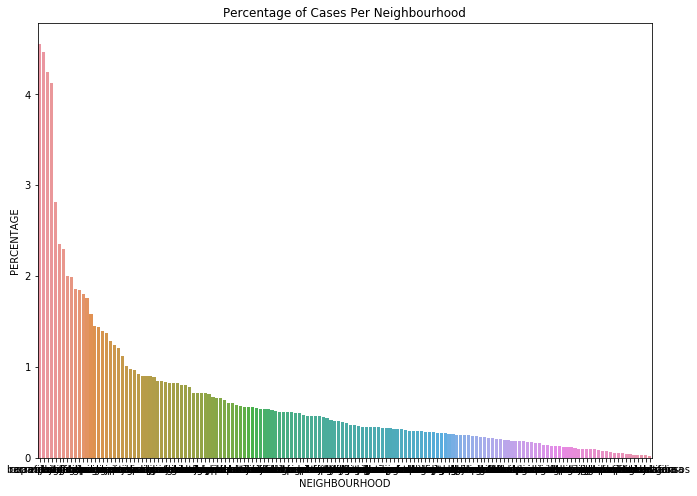

In [19]:
#Plotting data to help with visualization
dims = (11,8)
fig, ax = plt.subplots(figsize=dims)
ax.set_title('Percentage of Cases Per Neighbourhood')
graph_cases_percentage = sns.barplot(x='NEIGHBOURHOOD', y='PERCENTAGE', ax=ax, data=df_high_cases)
graph_cases_percentage

In [20]:
#Choosing a cutofff to create a dataframe with the neighbourhoods that are more affected
# 2% was chosen as the cutoff to determine which neighbourhoods should be focused
df_selected = df_high_cases[df_high_cases.PERCENTAGE > 2]
df_selected

,NEIGHBOURHOOD,TOTAL_CASES,LATITUDE,LONGITUDE,PERCENTAGE
35,copacabana,2768,-22.971964,-43.184343,4.557804
9,barra da tijuca,2713,-22.999740,-43.365993,4.467241
138,tijuca,2580,-22.933216,-43.238145,4.248242
23,campo grande,2507,-22.902953,-43.559129,4.128040
8,bangu,1708,-22.875305,-43.464880,2.812402
114,realengo,1432,-22.877274,-43.430103,2.357939
15,botafogo,1397,-22.948845,-43.179829,2.300308


In [23]:
#Creating new dataframe with hospitals from chosen neighbourhoods
df_chosen_hospitals = pd.merge(df_selected, rj_hospitals)

#Dropping unwanted information from dataframe
df_chosen_hospitals.drop(['TOTAL_CASES', 'LATITUDE', 'LONGITUDE', 'PERCENTAGE', 'NEIGHBOURHOOD LATITUDE', 'NEIGHBOURHOOD LONGITUDE'], axis=1, inplace = True)
df_chosen_hospitals.head()

,NEIGHBOURHOOD,HOSPITAL,HOSPITAL LATITUDE,HOSPITAL LONGITUDE
0,copacabana,Hospital San Magno,-22.969902,-43.187972
1,copacabana,Hospital Copa D'or,-22.968952,-43.187092
2,copacabana,Hospital Miguel Couto - Serviço de Neurocirurgia,-22.966908,-43.183690
3,copacabana,Pronto Atendimento Unimed Rio,-22.967771,-43.185715
4,barra da tijuca,Hospital Municipal Lourenço Jorge,-22.995239,-43.364740


In [24]:
#Add markers for chosen hospitals with their latitudes & longitudes
for lat, lng, name in zip(df_chosen_hospitals['HOSPITAL LATITUDE'], df_chosen_hospitals['HOSPITAL LONGITUDE'], df_chosen_hospitals['HOSPITAL']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng],popup=label).add_to(m)  
    
m


In [ ]:
#We can see that 20 hospitals were chosen. Let us further investigate to see if we can narrow this number

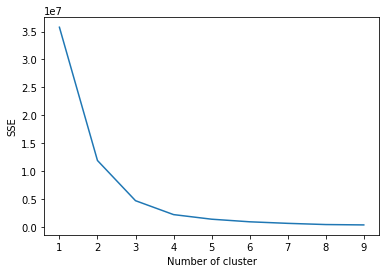

In [25]:
#Finding out the ideal number of K
temp_df = df_neighbourhood.drop('NEIGHBOURHOOD', 1)
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(temp_df)
    temp_df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [26]:
#We can see that after 4 clusters, there is no significant improvement. Thus, K equal to 4 will be used
kmeans =KMeans(n_clusters=4, random_state=0).fit(temp_df)

In [27]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
df_neighbourhood.insert(0, 'CLUSTER_LABELS', kmeans.labels_)



df_neighbourhood.head()

,CLUSTER_LABELS,NEIGHBOURHOOD,TOTAL_CASES,LATITUDE,LONGITUDE
0,3,abolicao,129,-22.886161,-43.299846
1,3,acari,105,-22.822153,-43.340674
2,3,agua santa,68,-22.911143,-43.312126
3,3,alto da boa vista,109,-22.962113,-43.253582
4,0,anchieta,497,-22.823190,-43.399107


In [28]:
#Plot the clusters centers in the map for visualization
df_centers = pd.DataFrame(data=kmeans.cluster_centers_)
df_centers.drop(3, axis=1, inplace=True)
df_centers.columns = ['VALUE', 'LATITUDE', 'LONGITUDE']
df_centers.insert(0, 'CLUSTER_LABELS', value=[0,1,2,3])
df_centers

,CLUSTER_LABELS,VALUE,LATITUDE,LONGITUDE
0,0,441.125000,-22.886023,-43.354317
1,1,1103.466667,-22.923384,-43.324542
2,2,2642.000000,-22.951968,-43.336903
3,3,139.741573,-22.880237,-43.287249


In [29]:
kclusters = 4
# create map
map_clusters2 = folium.Map(location=[latitude_RJ, longitude_RJ],tiles="Stamen Terrain", zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_centers['LATITUDE'], df_centers['LONGITUDE'], df_centers['CLUSTER_LABELS']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

In [30]:
# create map
map_clusters = folium.Map(location=[latitude_RJ, longitude_RJ],tiles="Stamen Terrain", zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_neighbourhood['LATITUDE'], df_neighbourhood['LONGITUDE'], df_neighbourhood['NEIGHBOURHOOD'], df_neighbourhood['CLUSTER_LABELS']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
#Find which hospitals are closer to the clusters with higher amount of cases

#Find cluster with highest number of cases and get its latitude & longitude
main_cluster = pd.DataFrame(df_centers.loc[df_centers['VALUE'].idxmax()])
main_cluster.drop(['CLUSTER_LABELS', 'VALUE'], axis=0, inplace=True)
main_cluster = pd.pivot_table(data=main_cluster, values=2, columns=['LATITUDE', 'LONGITUDE'])
main_cluster


,LATITUDE,LONGITUDE
2,-22.951968,-43.336903


In [32]:
#Coordinates of desired clusters
latc1 = -22.951968 #main_cluster['LATITUDE']
longc1 = -43.336903 #main_cluster['LONGITUDE']

In [33]:
#Create function to calculate the distance between centroid & hospitals
def DistHosp(lat_h, long_h, names, lat_c, long_c):
    list_dist = []

    coords_2 = (lat_c, long_c)
    for lat, long, name in zip(lat_h, long_h, names):
        coords_1 = (lat, long)
        result = geopy.distance.distance(coords_1, coords_2).km
        
        list_dist.append([
            name, 
            result])        
        
        #list_dist.append(name)
        #list_dist.append(result)
        
    dist_hospitals= pd.DataFrame(list_dist)

    return(dist_hospitals)

In [34]:
#Dataframe with hospitals and their distance from centroid
k_hospitals = DistHosp(lat_h=rj_hospitals['HOSPITAL LATITUDE'], long_h=rj_hospitals['HOSPITAL LONGITUDE'], names=rj_hospitals['HOSPITAL'], lat_c=latc1, long_c=longc1)
k_hospitals.columns = ['HOSPITAL', 'DISTANCE(KM)']
k_hospitals.head()

,HOSPITAL,DISTANCE(KM)
0,Hospital Psiquiatrico,7.848777
1,Hospital Federal do Andaraí,9.049702
2,Associação Dos Veteranos do Hospital Do Andarai,8.942221
3,Centro Cirúrgico,9.080999
4,Ambulatório,9.114053


In [40]:
#Dataframe with 20 closest hospitals from centroid
k_hospitals_chosen = k_hospitals.sort_values(by=['DISTANCE(KM)'], ascending=True)
c1_hospitals = k_hospitals_chosen.nsmallest(20, 'DISTANCE(KM)')
c1_hospitals.head()

,HOSPITAL,DISTANCE(KM)
147,Hospital Cardoso Fontes,5.509080
9,Hospital Municipal Lourenço Jorge,5.577774
11,BikeRio - Estação 108 Hospital Lourenço Jorge,5.620739
10,Hospital Lourenço Jorge,6.197632
129,Biolife Hospitalar,6.275018


In [41]:
#Merging 20 closest hospitals to centroid and 20 hospitals chosen by neighbourhood
#Merge is done by hospital name to find if we have any matches
c1_final = df_chosen_hospitals.merge(c1_hospitals, on='HOSPITAL')
c1_final

,NEIGHBOURHOOD,HOSPITAL,HOSPITAL LATITUDE,HOSPITAL LONGITUDE,DISTANCE(KM)
0,barra da tijuca,Hospital Municipal Lourenço Jorge,-22.995239,-43.364740,5.577774
1,barra da tijuca,Hospital Lourenço Jorge,-22.999743,-43.368382,6.197632
2,barra da tijuca,BikeRio - Estação 108 Hospital Lourenço Jorge,-22.995319,-43.365410,5.620739


In [ ]:
#All 3 hospitals are, in fact, the same, so we only have 1 match
#By looking at the map, we can see 5 "big" clusters of hospitals, so we will choose another 4 to better care for the distribution of cases

In [110]:
#Doing a visual inspection and google search to eliminate duplicates or entries that should not be chosen, such as Laboratoriums or Vets
#We can choose 5 final hospitals
df_final_hospitals=pd.DataFrame(columns= ['NEIGHBOURHOOD','HOSPITAL', 'HOSPITAL LATITUDE', 'HOSPITAL LONGITUDE'])

df_final_hospitals = df_final_hospitals.append(df_chosen_hospitals.iloc[0])
df_final_hospitals = df_final_hospitals.append(df_chosen_hospitals.iloc[4])
df_final_hospitals = df_final_hospitals.append(df_chosen_hospitals.iloc[8])
df_final_hospitals = df_final_hospitals.append(df_chosen_hospitals.iloc[10])
df_final_hospitals = df_final_hospitals.append(df_chosen_hospitals.iloc[13])
df_final_hospitals

,NEIGHBOURHOOD,HOSPITAL,HOSPITAL LATITUDE,HOSPITAL LONGITUDE
0,copacabana,Hospital San Magno,-22.969902,-43.187972
4,barra da tijuca,Hospital Municipal Lourenço Jorge,-22.995239,-43.364740
8,tijuca,Hospital Tijutrauma,-22.928568,-43.239529
10,campo grande,Hospital WestDor,-22.903854,-43.563569
13,bangu,Prosaúde Hospital de Clínicas,-22.879820,-43.463307


In [112]:
# Create Final Map of Rio de Janeiro
map_final = folium.Map(location=[latitude_RJ, longitude_RJ], tiles="Stamen Terrain", zoom_start=10.5)

# Add circles to identify hotspots
for lat, lng, name, value in zip(df_neighbourhood['LATITUDE'], df_neighbourhood['LONGITUDE'], df_neighbourhood['NEIGHBOURHOOD'], df_neighbourhood['TOTAL_CASES']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=value,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.4,
        parse_html=False).add_to(map_final)  


In [114]:
#Add markers for chosen hospitals with their latitudes & longitudes
for lat, lng, name in zip(df_final_hospitals['HOSPITAL LATITUDE'], df_final_hospitals['HOSPITAL LONGITUDE'], df_final_hospitals['HOSPITAL']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng],popup=label).add_to(map_final)  
    
map_final